In [ ]:
from keras import layers
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, concatenate, Flatten, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import numpy as np
from keras.applications.resnet_v2 import ResNet50V2
from keras.applications.inception_v3 import InceptionV3


In [ ]:
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, Lambda,Concatenate

batch_size = 32
img_height, img_width = 224, 224
input_shape = (img_height, img_width, 3)
epochs = 100
input_tensor = Input(shape = input_shape)

In [ ]:
base_model1=ResNet50V2(input_shape= input_shape,weights='imagenet', include_top=False, input_tensor=input_tensor)
for layer in base_model1.layers:
  layer.trainable=False
base_model1.summary()

94668760/94668760 [==============================] - 0s 0us/step
Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                        

In [ ]:
#a=base_model1.get_layer("conv5_block2_3_conv").outputconv3_block3_2_conv
a=base_model1.get_layer("conv3_block3_2_conv").output
a=MaxPooling2D()(a)
a=MaxPooling2D()(a)
b=base_model1.get_layer("conv4_block6_3_conv").output
c=base_model1.get_layer("conv3_block4_3_conv").output
c=MaxPooling2D()(c)
d=base_model1.get_layer("conv2_block3_3_conv").output
d=MaxPooling2D()(d)
d=MaxPooling2D()(d)
print(a.shape)
print(b.shape)
print(c.shape)
print(d.shape)
abcd=concatenate([a,b,c,d], axis=-1)
print(abcd.shape)


(None, 7, 7, 128)
(None, 7, 7, 1024)
(None, 7, 7, 512)
(None, 7, 7, 256)
(None, 7, 7, 1920)


In [ ]:
y = base_model1.output
conc=concatenate([y,abcd], axis=-1)
conc=BatchNormalization()(conc)
conc=Conv2D(2048, (1,1), activation='relu')(conc)
conc = GlobalAveragePooling2D()(conc)
print(conc.shape)

(None, 2048)


In [ ]:
base_model2=InceptionV3(input_shape= input_shape,weights='imagenet', include_top=False, input_tensor=input_tensor)
for layer in base_model2.layers:
  layer.trainable=False
base_model2.summary()


87910968/87910968 [==============================] - 1s 0us/step
Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_2 (Conv2D)              (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d_2[0][0]']               
 alization)           

In [ ]:
T=concatenate([conc,conc1], axis=-1)
print(T.shape)


(None, 4096)


In [ ]:
def add_specific_features(inputs):
    feature1 = inputs[0]
    feature2 = inputs[1]
    added_features = feature1 + feature2
    return added_features

added_features = Lambda(add_specific_features)([conc, conc1])

In [ ]:
from keras.layers import Conv2D, Dropout
print(added_features.shape)
T=Dropout(0.3)(T)

(None, 2048)


In [ ]:
T = Dense(256, activation='relu')(added_features)
predictions1 = Dense(3, activation='softmax')(T)
model3 = Model(inputs=input_tensor,outputs=predictions1)
model3.summary()
model3.compile(loss='CategoricalCrossentropy',optimizer='adam',metrics=['acc'] )

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [ ]:
print("Trainable Parameters:")
for layer in model3.trainable_weights:
    print(layer.name)

print(model3)

Trainable Parameters:
batch_normalization_105/gamma:0
batch_normalization_105/beta:0
batch_normalization_106/gamma:0
batch_normalization_106/beta:0
batch_normalization_107/gamma:0
batch_normalization_107/beta:0
batch_normalization_108/gamma:0
batch_normalization_108/beta:0
conv2d/kernel:0
conv2d/bias:0
batch_normalization_109/gamma:0
batch_normalization_109/beta:0
conv2d_1/kernel:0
conv2d_1/bias:0
conv2d_98/kernel:0
conv2d_98/bias:0
dense/kernel:0
dense/bias:0
dense_1/kernel:0
dense_1/bias:0


In [ ]:
print("Trainable Layers:")
for layer in model3.layers:
    if layer.trainable:
        print(layer.name)
        print(layer.count_params())
        print('---')

Trainable Layers:
max_pooling2d_36
0
---
max_pooling2d_39
0
---
max_pooling2d_37
0
---
max_pooling2d_38
0
---
max_pooling2d_40
0
---
concatenate_18
0
---
concatenate_24
0
---
concatenate_19
0
---
concatenate_25
0
---
batch_normalization_112
15872
---
batch_normalization_115
14336
---
conv2d_102
8128512
---
conv2d_105
7342080
---
global_average_pooling2d_4
0
---
global_average_pooling2d_7
0
---
lambda
0
---
dense_2
524544
---
dense_3
771
---


In [ ]:
print("Trainable Layers:")
for layer in model3.layers:
    if layer.trainable:
        print(layer.name)
        print(layer.output_shape)
        print(layer.count_params())
        print('---')

Trainable Layers:
max_pooling2d_36
(None, 14, 14, 128)
0
---
max_pooling2d_39
(None, 14, 14, 256)
0
---
max_pooling2d_37
(None, 7, 7, 128)
0
---
max_pooling2d_38
(None, 7, 7, 512)
0
---
max_pooling2d_40
(None, 7, 7, 256)
0
---
concatenate_18
(None, 7, 7, 1920)
0
---
concatenate_24
(None, 5, 5, 1536)
0
---
concatenate_19
(None, 7, 7, 3968)
0
---
concatenate_25
(None, 5, 5, 3584)
0
---
batch_normalization_112
(None, 7, 7, 3968)
15872
---
batch_normalization_115
(None, 5, 5, 3584)
14336
---
conv2d_102
(None, 7, 7, 2048)
8128512
---
conv2d_105
(None, 5, 5, 2048)
7342080
---
global_average_pooling2d_4
(None, 2048)
0
---
global_average_pooling2d_7
(None, 2048)
0
---
lambda
(None, 2048)
0
---
dense_2
(None, 256)
524544
---
dense_3
(None, 3)
771
---


In [ ]:
for layer in model3.layers:
    if layer.trainable:
        print(layer.name)
        print("Number of Parameters:", layer.count_params())
        if isinstance(layer, Conv2D):
            print("Kernel Size:", layer.kernel_size)
        print("Output Size:", layer.output_shape)
        print()

max_pooling2d_36
Number of Parameters: 0
Output Size: (None, 14, 14, 128)

max_pooling2d_39
Number of Parameters: 0
Output Size: (None, 14, 14, 256)

max_pooling2d_37
Number of Parameters: 0
Output Size: (None, 7, 7, 128)

max_pooling2d_38
Number of Parameters: 0
Output Size: (None, 7, 7, 512)

max_pooling2d_40
Number of Parameters: 0
Output Size: (None, 7, 7, 256)

concatenate_18
Number of Parameters: 0
Output Size: (None, 7, 7, 1920)

concatenate_24
Number of Parameters: 0
Output Size: (None, 5, 5, 1536)

concatenate_19
Number of Parameters: 0
Output Size: (None, 7, 7, 3968)

concatenate_25
Number of Parameters: 0
Output Size: (None, 5, 5, 3584)

batch_normalization_112
Number of Parameters: 15872
Output Size: (None, 7, 7, 3968)

batch_normalization_115
Number of Parameters: 14336
Output Size: (None, 5, 5, 3584)

conv2d_102
Number of Parameters: 8128512
Kernel Size: (1, 1)
Output Size: (None, 7, 7, 2048)

conv2d_105
Number of Parameters: 7342080
Kernel Size: (1, 1)
Output Size: (None

In [ ]:
training_data_dir='/home/iiitm/Desktop/Dataset/train'
training_data_generator = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True)
training_generator = training_data_generator.flow_from_directory(
    training_data_dir,
    target_size=(224,224),
    batch_size=32,
    class_mode="categorical")
validation_data_dir='/home/iiitm/Desktop/Dataset/validation'
validation_data_generator = ImageDataGenerator(rescale=1./255)
validation_generator = validation_data_generator.flow_from_directory(
    validation_data_dir,
    target_size=(224,224),
    batch_size=32,
    class_mode="categorical",
    shuffle=False)

# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi

!pip install psutil
!pip install humanize

import psutil
import humanize
import os



# XXX: only one GPU on Colab and isn’t guaranteed

def printm():
    process = psutil.Process(os.getpid())
    print("Gen RAM Free: " + humanize.naturalsize(psutil.virtual_memory().available), " |     Proc size: " + humanize.naturalsize(process.memory_info().rss))

printm()

Found 12157 images belonging to 3 classes.
Found 3219 images belonging to 3 classes.
ln: failed to create symbolic link '/usr/bin/nvidia-smi': Permission denied
Gen RAM Free: 1.6 GB  |     Proc size: 1.2 GB


In [ ]:
from keras.callbacks import ModelCheckpoint
filepath = "/home/iiitm/Desktop/march22/saved-model-{epoch:02d}-{loss:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=False, mode='min', save_freq = 'epoch' )

In [ ]:
#Training
H = model3.fit(
    training_generator,
    epochs=100,
    validation_data=validation_generator,
    callbacks=[checkpoint])

Epoch 1/100
380/380 [==============================] - ETA: 0s - loss: 0.3263 - acc: 0.8987
Epoch 1: saving model to /home/iiitm/Desktop/march22/saved-model-01-0.33.hdf5
380/380 [==============================] - 1472s 4s/step - loss: 0.3263 - acc: 0.8987 - val_loss: 0.4034 - val_acc: 0.8487
Epoch 2/100
380/380 [==============================] - ETA: 0s - loss: 0.1823 - acc: 0.9330
Epoch 2: saving model to /home/iiitm/Desktop/march22/saved-model-02-0.18.hdf5
380/380 [==============================] - 1172s 3s/step - loss: 0.1823 - acc: 0.9330 - val_loss: 0.2201 - val_acc: 0.9080
Epoch 3/100
380/380 [==============================] - ETA: 0s - loss: 0.1546 - acc: 0.9421
Epoch 3: saving model to /home/iiitm/Desktop/march22/saved-model-03-0.15.hdf5
380/380 [==============================] - 1093s 3s/step - loss: 0.1546 - acc: 0.9421 - val_loss: 0.2673 - val_acc: 0.8910
Epoch 4/100
380/380 [==============================] - ETA: 0s - loss: 0.1522 - acc: 0.9425
Epoch 4: saving model to /hom

Epoch 29/100
380/380 [==============================] - ETA: 0s - loss: 0.0532 - acc: 0.9810
Epoch 29: saving model to /home/iiitm/Desktop/march22/saved-model-29-0.05.hdf5
380/380 [==============================] - 1084s 3s/step - loss: 0.0532 - acc: 0.9810 - val_loss: 0.2365 - val_acc: 0.9329
Epoch 30/100
380/380 [==============================] - ETA: 0s - loss: 0.0496 - acc: 0.9826
Epoch 30: saving model to /home/iiitm/Desktop/march22/saved-model-30-0.05.hdf5
380/380 [==============================] - 1083s 3s/step - loss: 0.0496 - acc: 0.9826 - val_loss: 0.2724 - val_acc: 0.9323
Epoch 31/100
380/380 [==============================] - ETA: 0s - loss: 0.0520 - acc: 0.9801
Epoch 31: saving model to /home/iiitm/Desktop/march22/saved-model-31-0.05.hdf5
380/380 [==============================] - 1086s 3s/step - loss: 0.0520 - acc: 0.9801 - val_loss: 0.4738 - val_acc: 0.8692
Epoch 32/100
380/380 [==============================] - ETA: 0s - loss: 0.0436 - acc: 0.9836
Epoch 32: saving model

Epoch 57/100
380/380 [==============================] - ETA: 0s - loss: 0.0339 - acc: 0.9878
Epoch 57: saving model to /home/iiitm/Desktop/march22/saved-model-57-0.03.hdf5
380/380 [==============================] - 1092s 3s/step - loss: 0.0339 - acc: 0.9878 - val_loss: 0.2468 - val_acc: 0.9432
Epoch 58/100
380/380 [==============================] - ETA: 0s - loss: 0.0270 - acc: 0.9893
Epoch 58: saving model to /home/iiitm/Desktop/march22/saved-model-58-0.03.hdf5
380/380 [==============================] - 1090s 3s/step - loss: 0.0270 - acc: 0.9893 - val_loss: 0.2496 - val_acc: 0.9348
Epoch 59/100
380/380 [==============================] - ETA: 0s - loss: 0.0280 - acc: 0.9888
Epoch 59: saving model to /home/iiitm/Desktop/march22/saved-model-59-0.03.hdf5
380/380 [==============================] - 1086s 3s/step - loss: 0.0280 - acc: 0.9888 - val_loss: 0.2299 - val_acc: 0.9419
Epoch 60/100
380/380 [==============================] - ETA: 0s - loss: 0.0300 - acc: 0.9898
Epoch 60: saving model

Epoch 85/100
380/380 [==============================] - ETA: 0s - loss: 0.0277 - acc: 0.9898
Epoch 85: saving model to /home/iiitm/Desktop/march22/saved-model-85-0.03.hdf5
380/380 [==============================] - 1118s 3s/step - loss: 0.0277 - acc: 0.9898 - val_loss: 0.2335 - val_acc: 0.9491
Epoch 86/100
380/380 [==============================] - ETA: 0s - loss: 0.0197 - acc: 0.9927
Epoch 86: saving model to /home/iiitm/Desktop/march22/saved-model-86-0.02.hdf5
380/380 [==============================] - 1096s 3s/step - loss: 0.0197 - acc: 0.9927 - val_loss: 0.3553 - val_acc: 0.9208
Epoch 87/100
380/380 [==============================] - ETA: 0s - loss: 0.0181 - acc: 0.9933
Epoch 87: saving model to /home/iiitm/Desktop/march22/saved-model-87-0.02.hdf5
380/380 [==============================] - 1095s 3s/step - loss: 0.0181 - acc: 0.9933 - val_loss: 0.1578 - val_acc: 0.9559
Epoch 88/100
380/380 [==============================] - ETA: 0s - loss: 0.0197 - acc: 0.9925
Epoch 88: saving model

In [ ]:
model3.save('/home/iiitm/Desktop/march22/sci-model-march22.h5' )

In [ ]:
from keras.models import load_model
from sklearn.metrics import accuracy_score

model1 = load_model('/home/iiitm/Desktop/march22/saved-model-100-0.02.hdf5')

In [ ]:
test_data_dir='/home/iiitm/Desktop/dataset-new-try-2/path/train/'
test_data_generator = ImageDataGenerator(rescale=1./255)
test_generator = test_data_generator.flow_from_directory(
    test_data_dir,
    target_size=(224,224),
    batch_size=32,
    class_mode="categorical",
    shuffle=False)


from sklearn.metrics import accuracy_score,roc_curve, confusion_matrix, roc_auc_score, auc, f1_score
test_labels = test_generator.classes
num_classes = len(test_generator.class_indices)
test_labels = to_categorical(test_labels, num_classes=num_classes)
preds = model1.predict(test_generator)


predictions = [i.argmax() for i in preds]
y_true = [i.argmax() for i in test_labels]
cm = confusion_matrix(y_pred=predictions, y_true=y_true)

print('Accuracy {}'.format(accuracy_score(y_true=y_true, y_pred=predictions)))

Found 5896 images belonging to 3 classes.
Accuracy 0.9594640434192673


Confusion Matrix


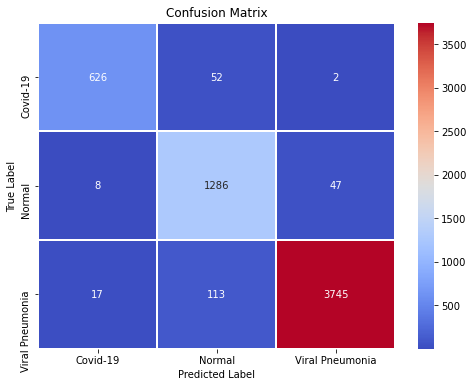

[[ 626   52    2]
 [   8 1286   47]
 [  17  113 3745]]
Classification Report
                 precision    recall  f1-score   support

       covid-19       0.96      0.92      0.94       680
         normal       0.89      0.96      0.92      1341
Viral Pneumonia       0.99      0.97      0.98      3875

       accuracy                           0.96      5896
      macro avg       0.94      0.95      0.95      5896
   weighted avg       0.96      0.96      0.96      5896



In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns


LABELS = ["Covid-19","Normal","Viral Pneumonia"]

def show_confusion_matrix(validations, predictions):
    matrix = confusion_matrix(validations, predictions)
    plt.figure(figsize=(8, 6))
    sns.heatmap(matrix,
                cmap="coolwarm",
                linecolor='white',
                linewidths=1,
                xticklabels=LABELS,
                yticklabels=LABELS,
                annot=True,
                fmt="d")
    plt.title("Confusion Matrix")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.savefig('/home/iiitm/Desktop/march22/confusion-conference.jpg', dpi=300)
    plt.show()

filenames = test_generator.filenames
nb_samples = len(filenames)

Y_pred =preds
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
show_confusion_matrix(test_generator.classes, y_pred)
print(confusion_matrix(test_generator.classes, y_pred))
print('Classification Report')
target_names = ["covid-19","normal","Viral Pneumonia"]
print(classification_report(test_generator.classes, y_pred, target_names=target_names))
# Plot linewidth.
lw = 2




In [ ]:
def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    fig1 = plt.gcf()
    plt.show()
    plt.draw()
    fig1.savefig('/home/iiitm/Desktop/march22/roc-curve-conference.jpg', dpi=300)


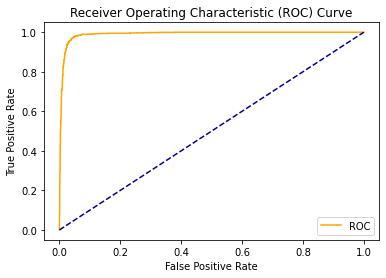

<Figure size 432x288 with 0 Axes>

In [ ]:
probs = Y_pred[:, 1]

fpr, tpr, thresholds = roc_curve(test_generator.classes, probs, pos_label=1)
roc_display =plot_roc_curve(fpr=fpr, tpr=tpr)

In [ ]:
from keras.utils.vis_utils import plot_model

In [ ]:
plot_model(model1, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [ ]:
pip install pydot

  Using cached pydot-1.4.2-py2.py3-none-any.whl (21 kB)
Note: you may need to restart the kernel to use updated packages.


In [ ]:
pip install graphviz

     |████████████████████████████████| 46 kB 190 kB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.
